In [19]:
import pandas as pd

btvote = pd.read_pickle('../data/btvote_imputed.pkl')
btvote.head()

,vote_19001,vote_19002,vote_19003,vote_19004,vote_19005,vote_19006,vote_19007,vote_19008,vote_19009,vote_19010,...,vote_19236,vote_19237,vote_19238,vote_19239,vote_19240,vote_19241,vote_19242,vote_19243,vote_19244,party
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,CDU/CSU
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,SPD
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Linke
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,CDU/CSU
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Linke


# Split data and encode target variable

In [22]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Split data into stratified train and test split
# train split will be used to find best model setting 
btvote_data_train, btvote_data_test, btvote_target_train, btvote_target_test = train_test_split(btvote_data, btvote_target, test_size=0.25, random_state=42, shuffle=True, stratify=btvote_target)

# GridSearch setup

As the data is already imputed and no balancing is needed, we don't need a pipeline.

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define the scoring function
# We use 'macro' as average as we want to evaluate the performance of each class equally, regardless of the class size
f1 = make_scorer(f1_score, average='macro')

# Baseline

We want to find a baseline for the F1 score in the given problem. A common baseline approach is to predict the most frequent class label in the training set for all test items.
In our case this would mean to predict 'CDU/CSU' (most represented party) for all MPs while ignoring their voting behavior.

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# We use stratified 10 fold cross validation
print('Cross Validated Baseline: {}'.format(cross_val_score(DummyClassifier(strategy="most_frequent"), btvote_data_train, btvote_target_train, cv=stratified_10_fold_cv, scoring=f1).mean()))

Cross Validated Baseline: 0.08631009957325746


# k-NN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# set parameter grid
parameters = {
    'n_neighbors': range(2, 10),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # For Minkowski distance (1 for Manhattan, 2 for Euclidean)'
}

# create the grid search instance
grid_search_estimator = GridSearchCV(KNeighborsClassifier(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['n_neighbors'] = results['param_n_neighbors'].astype(str)
results['weights'] = results['param_weights'].astype(str)
results['metric'] = results['param_p'].replace({1:'manhattan', 2:'euclidean'})
results['ranking'] = results['rank_test_score'].astype(int)
pivoted_results = results.pivot(index=['n_neighbors','weights'], columns='metric', values=['mean_test_score', 'ranking'])
pivoted_results['ranking'] = pivoted_results['ranking'].astype(int)
display(pivoted_results)

mean_test_score             ranking          
metric                     euclidean manhattan euclidean manhattan
n_neighbors weights                                               
2           distance        0.832154  0.825988        27        29
            uniform         0.813371  0.808027        31        32
3           distance        0.865122  0.859869         4        14
            uniform         0.864372  0.859694         6        15
4           distance        0.842799  0.834444        25        26
            uniform         0.829126  0.825144        28        30
5           distance        0.866111  0.863029         3        10
            uniform         0.868099  0.864153         1         7
6           distance        0.865120  0.862823         5        11
            uniform         0.867272  0.863524         2         8
7           distance        0.863237  0.860205         9        13
            uniform         0.860981  0.857786        12        18
8           distance        0.859590  0.854604        16        21
            uniform         0.859480  0.852322        17        23
9           distance        0.856788  0.854837        19        20
            uniform         0.852664  0.848482        22        24

Using distance based weights doesn't always perform better than uniform weights. The euclidean distance generally performs as least as good as manhattan distance.

The best parameter setting for the k-NN is n_neighbors=5, distance='euclidean' (p=2), and weights='uniform', which are all default values. The F1 score is 0.868.

# Nearest Centroid

In [27]:
from sklearn.neighbors import NearestCentroid

# set parameter grid
parameters = {
    'metric': ['manhattan', 'euclidean']
}

# create the grid search instance
grid_search_estimator = GridSearchCV(NearestCentroid(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['metric'] = results['param_metric']
results['ranking'] = results['rank_test_score']
display(results[['metric','mean_test_score','ranking']])

,metric,mean_test_score,ranking
0,manhattan,0.811641,2
1,euclidean,0.855236,1


Here, using euclidean distance performs better than manhattan distance.

The best parameter setting for the Nearest Centroid is metric='euclidean', which is the default value. The F1 score is 0.855

# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

# set parameter grid
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(DecisionTreeClassifier(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['criterion'] = results['param_criterion'].astype(str)
results['max_depth'] = results['param_max_depth'].astype(str)
results['min_samples_split'] = results['param_min_samples_split']
pivoted_results = results.pivot(index=['criterion','max_depth'], columns='min_samples_split', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc[('Average',''),:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_32776\2065465406.py:24: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index=['criterion','max_depth'], columns='min_samples_split', values='mean_test_score')


min_samples_split           2         5        10   Average
criterion max_depth                                        
entropy   10         0.840985  0.840675  0.839816  0.840492
          15         0.843407  0.840687  0.843008  0.842367
          5          0.830246  0.830246  0.830246  0.830246
          None       0.858128  0.851267  0.852138  0.853844
gini      10         0.857728  0.855738  0.853554  0.855673
          15         0.860620  0.856683  0.856864  0.858056
          5          0.838543  0.838543  0.838543  0.838543
          None       0.860279  0.860622  0.859093  0.859998
Average              0.848742  0.846808  0.846658  0.847403

Observations:
- max_depth: choosing a max_depth of 5 and 10 works not as good as 15. For 15 and None, the results are similar.
- min_samples_split: On average, there are no real differences, 2 works slightly better.
- criterion: For a larger max_depth, the top values can be achieved for using gini.

We choose criterion='gini' (default), max_depth=15 and min_samples_split=2 (default) as the best parameter setting for a DecisionTreeClassifier.

# Naïve Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

model = GaussianNB()

print('Cross-validated F1 score: {}'.format(cross_val_score(model, btvote_data_train, btvote_target_train, scoring=f1, cv=stratified_10_fold_cv).mean()))

Cross-validated F1 score: 0.8350390681618751


# Interim conclusion

Up until now, we considered the models, that have been dealt with in detail in the lecture.

F1 score of the best parameter setting for each model: 
- k-NN: 0.868
- Nearest Centroid: 0.855
- Decision Tree: 0.861
- Naïve Bayes: 0.835

Out of these four models, the k-NN performs the best with the Decision Tree close behind.

# Neural Network

In [31]:
from sklearn.neural_network import MLPClassifier

# set parameter grid
parameters = {
    'hidden_layer_sizes': [(50), (50, 50), (100, 50, 25), (100, 50, 25, 10)], # Specify the architecture of hidden layers
    'alpha': [0.0001, 0.001, 0.01], # L2 regularization term
    'max_iter': [300], # Increase number of gradient steps so that all combinations convert
    'random_state': [42],  # Random seed for reproducibility
}

# create the grid search instance
grid_search_estimator = GridSearchCV(MLPClassifier(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['hidden_layer_sizes'] = results['param_hidden_layer_sizes'].astype(str)
results['alpha'] = results['param_alpha']
pivoted_results = results.pivot(index='hidden_layer_sizes', columns='alpha', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc['Average',:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_32776\1887420654.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index='hidden_layer_sizes', columns='alpha', values='mean_test_score')


alpha,0.0001,0.001,0.01,Average
hidden_layer_sizes,,,,
"(100, 50, 25)",0.839571,0.854125,0.838751,0.844149
"(100, 50, 25, 10)",0.834268,0.831551,0.837471,0.834430
"(50, 50)",0.838726,0.846005,0.842916,0.842549
50,0.852778,0.851667,0.845233,0.849892
Average,0.841336,0.845837,0.841093,0.842755


Using more hidden layers doesn't lead to a higher F1 score. The best results can be achieved for a single hidden layer of size 50. In that case, the alpha parameter 0.0001 produces the best result.

The best parameter setting for the MLPClassifier is hidden_layer_sizes=(50), alpha=0.0001, max_iter=300. The F1 score is 0.853.

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

# set parameter grid
parameters = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'n_estimators': [10, 50, 100, 150, 200],  # Number of trees in the forest
    'random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(RandomForestClassifier(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['criterion'] = results['param_criterion'].astype(str)
results['n_estimators'] = results['param_n_estimators']
pivoted_results = results.pivot(index='criterion', columns='n_estimators', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc['Average',:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_32776\2151437375.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index='criterion', columns='n_estimators', values='mean_test_score')


n_estimators,10,50,100,150,200,Average
criterion,,,,,,
entropy,0.853252,0.858115,0.861708,0.868856,0.868562,0.862098
gini,0.855685,0.859381,0.858115,0.867589,0.867589,0.861672
Average,0.854468,0.858748,0.859911,0.868223,0.868076,0.861885


The criterion doesn't significantly affect the result. The maximum F1 score can be achieved using n_estimators=150. We take the combination ('entropy', 150) as it has best result. Now, we will use this pair to evaluate the effect of max_depth and min_samples_split.

In [33]:
# set parameter grid
parameters = {
    'criterion': ['entropy'],
    'n_estimators': [150],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(RandomForestClassifier(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['max_depth'] = results['param_max_depth']
results['min_samples_split'] = results['param_min_samples_split']
pivoted_results = results.pivot(index='max_depth', columns='min_samples_split', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc['Average',:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_32776\2720907532.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index='max_depth', columns='min_samples_split', values='mean_test_score')


min_samples_split,2,5,10,Average
max_depth,,,,
NaN,0.868856,0.862957,0.865987,0.865933
10.0,0.830189,0.829981,0.830189,0.830120
20.0,0.840719,0.839311,0.842574,0.840868
30.0,0.860912,0.857881,0.859279,0.859357
40.0,0.867589,0.862957,0.865987,0.865511
50.0,0.868856,0.862957,0.865987,0.865933
60.0,0.868856,0.862957,0.865987,0.865933
Average,0.857997,0.854143,0.856570,0.856237


The default min_samples_split value 2 performs the best. A max_depth of 50 maximizes the F1 score.

Finally the best parameter setting for the Random Forest classifier is criterion='entropy', n_estimators=150, max_depth=50, and min_samples_split=2 (default). The F1 score is 0.869.

# Support Vector Machine

In [35]:
from sklearn.svm import SVC

# set parameter grid
parameters = {
    'C': [0.1, 1.0, 10, 20, 50, 100], # regularization parameter
    'kernel': ['linear', 'rbf'], # kernel type used in the algorithm
    'gamma': ['scale', 'auto'], # kernel coefficient parameter for 'rbf'
    'random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(SVC(), parameters, scoring=f1, cv=stratified_10_fold_cv)

# run the grid search
grid_search_estimator.fit(btvote_data_train, btvote_target_train)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
results['kernel'] = results['param_kernel'].astype(str)
results['gamma'] = results['param_gamma'].astype(str)
results['C'] = results['param_C']
pivoted_results = results.pivot(index=['kernel','gamma'], columns='C', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc[('Average',''),:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_32776\4210631860.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index=['kernel','gamma'], columns='C', values='mean_test_score')


C                   0.1       1.0      10.0      20.0      50.0     100.0  \
kernel  gamma                                                               
linear  auto   0.806992  0.836101  0.836889  0.835384  0.841091  0.838727   
        scale  0.806992  0.836101  0.836889  0.835384  0.841091  0.838727   
rbf     auto   0.785385  0.788182  0.804363  0.812282  0.826384  0.836101   
        scale  0.788182  0.793832  0.815466  0.828984  0.834704  0.836201   
Average        0.796888  0.813554  0.823402  0.828008  0.835818  0.837439   

C               Average  
kernel  gamma            
linear  auto   0.832531  
        scale  0.832531  
rbf     auto   0.808783  
        scale  0.816228  
Average        0.822518

Using a linear kernel performs significantly better than the rbf kernel. In that case the gamma parameter is irrelevant. The F1 score reaches its maximum with C=50.

The best parameter setting for SVM is kernel='linear', C=50. The F1 score is 0.841.

# Conclusion

Finally, we compare the k-NN with the three alternative approaches.

F1 score of the best parameter setting for each model: 
- k-NN: 0.868
- Neural Network: 0.853
- Random Forest: 0.869
- Support Vector Machine: 0.841

Out of these four models, the k-NN and the Random Forest perform approximately equally good.

The k-NN model has the advantage in terms of simplicity and interpretability. Since the performance is equally good for both models, Occam's Razor favors the simpler one of the two, which is the k-NN. Nevertheless, when selecting the features in the next notebook, we will once again consider the Random Forest classifier as an option.

We finally declare k-NN with n_neighbors=5, distance='euclidean' (p=2), and weights='uniform' (all default values) as the best model for our classification task.

We further evaluate this model on unseen data using the test set, we generated before performing the classification. 

# Further k-NN evaluation

In [37]:
from sklearn.metrics import classification_report

# define the best model again
best_model = KNeighborsClassifier()

# fit model on training data
best_model.fit(btvote_data_train, btvote_target_train)

# get predictions for test data
prediction = best_model.predict(btvote_data_test)

# generate classification report from predictions
print(classification_report(btvote_target_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.75      0.45      0.57        66
           2       1.00      0.95      0.98        21
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        18
           5       0.46      0.76      0.57        41

    accuracy                           0.75       187
   macro avg       0.87      0.86      0.85       187
weighted avg       0.79      0.75      0.75       187



The scores on our test data are:
- accuracy: 0.75
- macro precision: 0.87
- macro recall: 0.86
- macro F1 score: 0.85

The only classes with significant performance issues are 1 (CDU/CSU) and 5 (SPD).

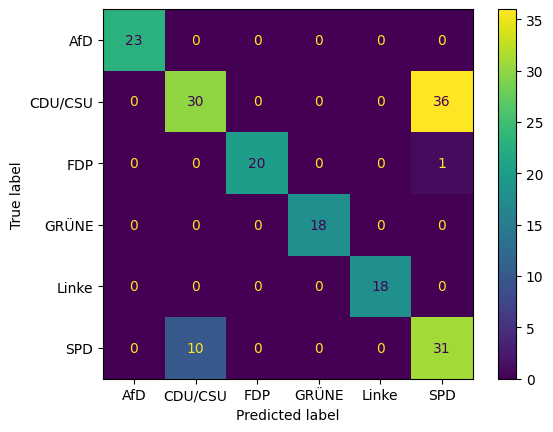

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot()

plt.show()

The confusion matrix validates, that most of the false predictions result from errors between CDU/CSU and SPD.

For six random train/test examples, we see that the difficulty always lies with differentiating between CDU/CDU and SPD. Sometimes more SPD MPs are classified as CDU/CSU, sometimes the other way around.